# RXRX.AI

> disclosure: some lines of code were taken from other kernels available on the Kaggle's competition link https://www.kaggle.com/c/recursion-cellular-image-classification/kernels . Authors will be cited as much as possible where appropriate.   

> disclosure 2: this notebook assumes GPU accessibility.

In [6]:
!git clone https://github.com/recursionpharma/rxrx1-utils.git && mv rxrx1-utils rxrxutils

Cloning into 'rxrx1-utils'...
remote: Enumerating objects: 118, done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (118/118), 1.59 MiB | 0 bytes/s, done.
Resolving deltas: 100% (59/59), done.


In [7]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rxrxutils.rxrx.io as rio
from scipy import misc

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

from torchvision import models, transforms

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
# Data folder overview
!ls -1 ../input

pixel_stats.csv
recursion_dataset_license.pdf
sample_submission.csv
test
test.csv
test_controls.csv
train
train.csv
train_controls.csv


## Loading a site and visualizing individual channels

This exploration is inspired by the competition's [creator notebook](https://colab.research.google.com/github/recursionpharma/rxrx1-utils/blob/master/notebooks/visualization.ipynb) and [utils](https://github.com/recursionpharma/rxrx1-utils).   
  
The input for our model will be a 512x512x6 image tensor representing a site, so we will make sure the utilities provided load the site as a tensor with the proper shape. Here, we request the image in experiment RPE-05 on plate 3 in well D19 at site 2.

In [10]:
t = rio.load_site('train', 'RPE-05', 3, 'D19', 2, base_path="../input")
print(t.shape)
t_tensor_default = transforms.ToTensor()(t)
print(t_tensor_default.shape)

(512, 512, 6)
torch.Size([6, 512, 512])


This seems to work, now let's visualize individual channels.

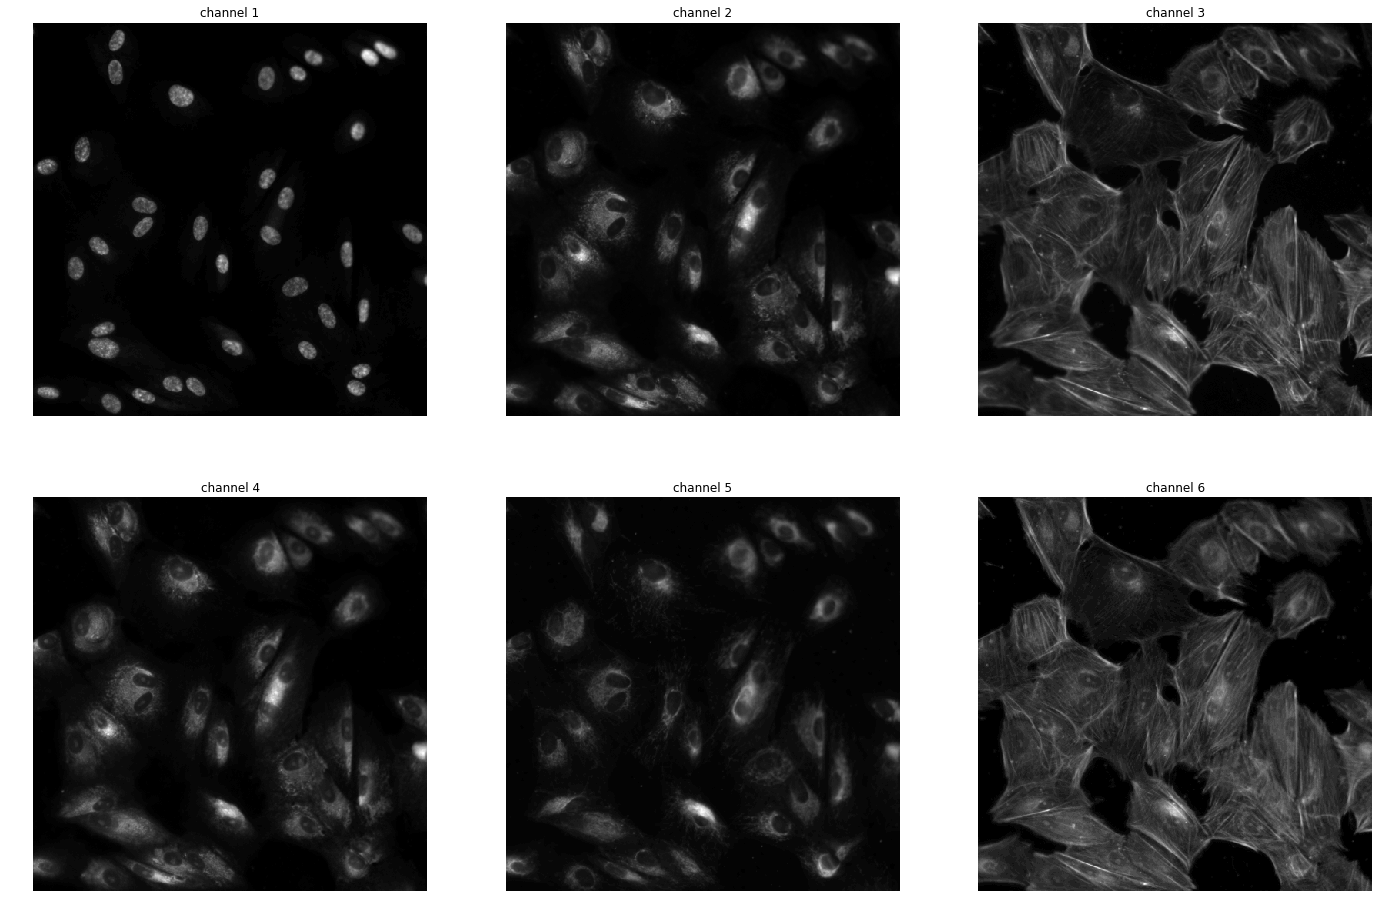

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title('channel {}'.format(i + 1))
  _ = ax.imshow(t[:, :, i], cmap='gray')

With the utils provided, we can also convert a site to a RGB format with the `convert_tensor_to_rgb` method. It associates an RGB color with each channel, then aggregates the color channels across the six cellular channels.   

(512, 512, 3)


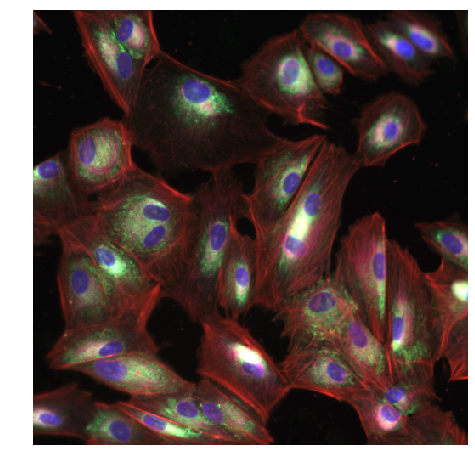

In [12]:
x = rio.convert_tensor_to_rgb(t)
print(x.shape)

# plot RGB Image
plt.figure(figsize=(8, 8))
plt.axis('off')
_ = plt.imshow(x)

The utils also include a wrapper `load_site_as_rgb` combining the last two functions.

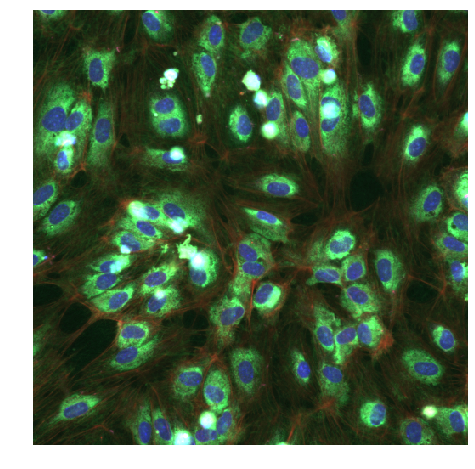

In [13]:
y = rio.load_site_as_rgb('train', 'HUVEC-07', 4, 'K09', 1)

plt.figure(figsize=(8, 8))
plt.axis('off')

_ = plt.imshow(y)

In [14]:
# convert to Tensor
y_tensor = transforms.ToTensor()(y)
print(y_tensor.shape)

torch.Size([3, 512, 512])


#### Using 6-channel for the base model

For training the base model, we will use the 6-channel method `rio.load_site` to convert images from a site to a 6x512x512 pytorch Tensor, because it will take less time to load and transform images. Also, it may be possible that opting for a 6-channel approach prevents losing information about the site. 

#### Metadata

The metadata for RxRx1 during the Kaggle competition is broken up into four files: train.csv, train_controls.csv, test.csv and test_controls.csv. It is often more convenient to view all the metadata at once, so we have provided a helper function called combine_metadata for doing just that.

In [15]:
md = rio.combine_metadata()
md.head()

cell_type dataset experiment  plate   sirna  site well  \
id_code                                                                 
HEPG2-08_1_B02     HEPG2    test   HEPG2-08      1  1138.0     1  B02   
HEPG2-08_1_B02     HEPG2    test   HEPG2-08      1  1138.0     2  B02   
HEPG2-08_1_B03     HEPG2    test   HEPG2-08      1     NaN     1  B03   
HEPG2-08_1_B03     HEPG2    test   HEPG2-08      1     NaN     2  B03   
HEPG2-08_1_B04     HEPG2    test   HEPG2-08      1     NaN     1  B04   

                       well_type  
id_code                           
HEPG2-08_1_B02  negative_control  
HEPG2-08_1_B02  negative_control  
HEPG2-08_1_B03         treatment  
HEPG2-08_1_B03         treatment  
HEPG2-08_1_B04         treatment

## Loading images & base model training

This part is dedicated to create a base model for comparison with full-blown solutions. The flow and some ideas were drawn from [Michael Diskin kernel](https://www.kaggle.com/yhn112/resnet18-baseline-pytorch-ignite).

In [16]:
path_data = '../input'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)
classes = 1108
batch_size = 32

cuda


### Implement dataset class & loaders

As seen in the _Loading a site and visualizing individual channels_ , useful methods were provided to easily load images to pass to our model later on. We will use `rio.load_site` to load site images and convert them to 6x512x512 tensors in our Pytorch image dataset class (ImageDS).

In [17]:
class ImagesDS(D.Dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def __init__(self, df, mode='train', site=1, channels=[1,2,3,4,5,6]):
        self.records = df.to_records(index=False)
        self.channels = channels
        self.site = site
        self.mode = mode
        self.len = df.shape[0]
        self.first = None
        
    def _get_img(self, index):
        record = self.records[index]
        return transforms.ToTensor()(rio.load_site(self.mode, record.experiment, record.plate, record.well, self.site, base_path=path_data)).float().cuda()
        
    def __getitem__(self, index):
        img = self._get_img(index)
        if self.mode == 'train':
            return img, int(self.records[index].sirna)
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

In [26]:
# dataframes for training, cross-validation, and testing
df = pd.read_csv(path_data+'/train.csv')
df_train, df_val = train_test_split(df, test_size = 0.025, random_state=42)
df_test = pd.read_csv(path_data+'/test.csv')

# pytorch training dataset & loader
ds = ImagesDS(df_train, mode='train')
loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

# pytorch cross-validation dataset & loader
ds_val = ImagesDS(df_val, mode='train')
val_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=0)

# pytorch test dataset & loader
ds_test = ImagesDS(df_test, mode='test')
tloader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

### Prepare base model   

For our base model, we will use a simple model architecture that will output 1108 classes, since our goal is to classify images into 1108 different siRNA modifications. The simple model architecture was inspired by [Pytorch's tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and  adapted for the problem at hand.

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(6, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(64 * 32 * 32, 2216, bias=False)
        self.fc2 = nn.Linear(2216, 1108, bias=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
model.cuda()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(6, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (fc1): Linear(in_features=65536, out_features=2216, bias=False)
  (fc2): Linear(in_features=2216, out_features=1108, bias=False)
)

In [22]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

metrics = {
    'loss': Loss(criterion),
    'accuracy': Accuracy(),
}

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    metrics = val_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} "
          .format(engine.state.epoch, 
                      metrics['loss'], 
                      metrics['accuracy']))

checkpoints = ModelCheckpoint('models', 'Model', save_interval=1, n_saved=2, create_dir=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoints, {'BaseModel': model})

pbar = ProgressBar(bar_format='')
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

trainer.run(loader, max_epochs=2)

Validation Results - Epoch: 1  Average Loss: 6.8600 | Accuracy: 0.0011 


Validation Results - Epoch: 2  Average Loss: 6.8433 | Accuracy: 0.0011 


In [23]:
model.eval()
with torch.no_grad():
    preds = np.empty(0)
    for x, _ in tqdm_notebook(tloader): 
        x = x.to(device)
        output = model(x)
        idx = output.max(dim=-1)[1].cpu().numpy()
        preds = np.append(preds, idx, axis=0)

In [24]:
submission = pd.read_csv(path_data + '/test.csv')
submission['sirna'] = preds.astype(int)
submission.to_csv('submission.csv', index=False, columns=['id_code','sirna'])

<a href="submission.csv">Download submission file for Base Model</a>

## Conclusion

This gives us a cross-validation score of `0.0011` (`.1%` accuracy), and a test score of 0.002 (`.2%` accuracy). This score is a bit better than chance since we have 1108 classes. An accuracy reflecting chance would be 1/1108, which is equivalent to ~0.09% accuracy. We will explore how we can improve on this score in a next kernel.